In [1]:
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import os
from datetime import datetime
import albumentations
import numpy as np

In [2]:
annot_data = pd.read_csv("../input/data/BBox_List_2017.csv")

In [3]:
len(annot_data)

984

In [4]:
len(annot_data["Image Index"].unique())

880

In [5]:
annot_data.columns

Index(['Image Index', 'Finding Label', 'Bbox [x', 'y', 'w', 'h]', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8'],
      dtype='object')

In [6]:
annot_data.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [7]:
annot_data["Unnamed: 6"].unique()

array([nan])

In [8]:
annot_data["Unnamed: 7"].unique()

array([nan])

In [9]:
annot_data["Unnamed: 8"].unique()

array([nan])

In [10]:
annot_data = annot_data.drop(["Unnamed: 6","Unnamed: 7","Unnamed: 8" ], axis=1)

In [11]:
annot_data["Finding Label"].unique()

array(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass',
       'Nodule', 'Pneumonia', 'Pneumothorax'], dtype=object)

In [12]:
annot_data["Finding Label"].value_counts()

Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: Finding Label, dtype: int64

### Deleting Pneumonia, since it does not overlap with VBD_CXR dataset

In [13]:
len(annot_data[annot_data["Finding Label"]=="Pneumonia"]["Image Index"].unique())

120

In [14]:
# https://www.geeksforgeeks.org/how-to-drop-rows-in-dataframe-by-conditions-on-column-values/
index_names = annot_data[annot_data['Finding Label'] == "Pneumonia" ].index 
  
# drop these row indexes 
# from dataFrame 
annot_data = annot_data.drop(index_names) 

In [15]:
len(annot_data)

864

In [16]:
len(annot_data["Image Index"].unique())

783

In [17]:
annot_data["Finding Label"].value_counts()

Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumothorax     98
Mass             85
Nodule           79
Name: Finding Label, dtype: int64

Combine Nodule and Mass into single label to match with VBD_CXR data

In [18]:
# https://www.statology.org/pandas-replace-values/
annot_data = annot_data.replace({"Mass":"Nodule/Mass", "Nodule":"Nodule/Mass", "Effusion":"Pleural effusion", "Infiltrate":"Infiltration"})

In [19]:
annot_data["Finding Label"].value_counts()

Atelectasis         180
Nodule/Mass         164
Pleural effusion    153
Cardiomegaly        146
Infiltration        123
Pneumothorax         98
Name: Finding Label, dtype: int64

Convert data to Pascal VOC

In [20]:
annot_data.head()

,Image Index,Finding Label,Bbox [x,y,w,h]
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695


In [21]:
# convert Finding label into class_ids
label2id = {
        "Aortic enlargement": 0,
        "Atelectasis": 1,
        "Calcification": 2,
        "Cardiomegaly": 3,
        "Consolidation": 4,
        "ILD": 5,
        "Infiltration": 6,
        "Lung Opacity": 7,
        "Nodule/Mass": 8,
        "Other lesion": 9,
        "Pleural effusion": 10,
        "Pleural thickening": 11,
        "Pneumothorax": 12,
        "Pulmonary fibrosis": 13,
        "No findings": 14,
    }

annot_data = annot_data.replace(label2id)

In [22]:
annot_data.head()

,Image Index,Finding Label,Bbox [x,y,w,h]
0,00013118_008.png,1,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,1,686.101695,131.543498,185.491525,313.491525
2,00029817_009.png,1,221.830508,317.053115,155.118644,216.949153
3,00014687_001.png,1,726.237288,494.951420,141.016949,55.322034
4,00017877_001.png,1,660.067797,569.780787,200.677966,78.101695


In [23]:
#https://www.geeksforgeeks.org/how-to-rename-columns-in-pandas-dataframe/
# rename column names of annot_data
annot_data = annot_data.rename(columns = {'Image Index':'image_id', "Finding Label":"class_id", "Bbox [x":"x_min", "y":"y_min", "w":"w", "h]":"h"}) 


In [24]:
sample = Image.open("../input/data/images_006/images/00013118_008.png")

In [25]:
sample.size

(1024, 1024)

In [26]:
def get_label_2_color_dict():
    label2color = {
        0: ("Aortic enlargement", "#2a52be"),
        1: ("Atelectasis", "#ffa812"),
        2: ("Calcification", "#ff8243"),
        3: ("Cardiomegaly", "#4682b4"),
        4: ("Consolidation", "#ddadaf"),
        5: ("ILD", "#a3c1ad"),
        6: ("Infiltration", "#008000"),
        7: ("Lung Opacity", "#004953"),
        8: ("Nodule/Mass", "#e3a857"),
        9: ("Other lesion", "#dda0dd"),
        10: ("Pleural effusion", "#e6e8fa"),
        11: ("Pleural thickening", "#800020"),
        12: ("Pneumothorax", "#918151"),
        13: ("Pulmonary fibrosis", "#e75480"),
        14: ("No findings", "#FFFFFF"),
    }

    return label2color

In [27]:
def bounding_box_plotter_yolo(img_as_arr, img_id, bounding_boxes_info, label2color,
                         label_annotations=True):
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot()

    # plot the image
    plt.imshow(img_as_arr, cmap="gray")
    plt.title(img_id)

    # add the bounding boxes
    for row in bounding_boxes_info:
        # each row contains 'x_min', 'y_min', 'w', 'h', "class_id"
        xmin = row[0]
        ymin = row[1]
        width = row[2]
        height = row[3]
        xmax = xmin + width
        ymax = ymin + height

        # assign different color to different classes of objects
        edgecolor = label2color[row[4]][1]

        if label_annotations:
            ax.annotate(label2color[row[4]][0], xy=(xmax - 40, ymin + 20))

        # add bounding boxes to the image
        rect = patches.Rectangle((xmin, ymin), width, height, edgecolor=edgecolor, facecolor='none')

        ax.add_patch(rect)
    plt.tight_layout()
    plt.show()

In [28]:
def get_bb_info(df, img_id, columns):
    # returns numpy array
    return df[df["image_id"]==img_id][columns].values

In [29]:
img_as_arr = np.asarray(sample)

In [30]:
img_as_arr.shape

(1024, 1024)

In [31]:
# 'x_min', 'y_min', 'w', 'h', "class_id"
bb_info = get_bb_info(annot_data, "00013118_008.png", ["x_min","y_min","w","h", "class_id"])

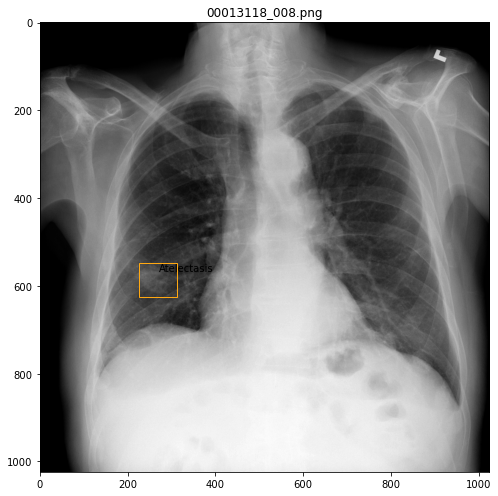

In [32]:
bounding_box_plotter_yolo(img_as_arr, "00013118_008.png", bb_info, get_label_2_color_dict())

### Convert YOLO to Pascal VOC

In [33]:
def bounding_box_plotter_pascal_voc(img_as_arr, img_id, bounding_boxes_info, label2color,
                         label_annotations=True):
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot()

    # plot the image
    plt.imshow(img_as_arr, cmap="gray")
    plt.title(img_id)

    # add the bounding boxes
    for row in bounding_boxes_info:
        # each row contains 'x_min', 'y_min', 'x_max', 'y_max', "class_id"
        xmin = row[0]
        ymin = row[1]
        xmax = row[2]
        ymax = row[3]
        width = xmax - xmin
        height = ymax - ymin 
        

        # assign different color to different classes of objects
        edgecolor = label2color[row[4]][1]

        if label_annotations:
            ax.annotate(label2color[row[4]][0], xy=(xmax - 40, ymin + 20))

        # add bounding boxes to the image
        rect = patches.Rectangle((xmin, ymin), width, height, edgecolor=edgecolor, facecolor='none')

        ax.add_patch(rect)
    plt.tight_layout()
    plt.show()

In [34]:
annot_data.head()

,image_id,class_id,x_min,y_min,w,h
0,00013118_008.png,1,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,1,686.101695,131.543498,185.491525,313.491525
2,00029817_009.png,1,221.830508,317.053115,155.118644,216.949153
3,00014687_001.png,1,726.237288,494.951420,141.016949,55.322034
4,00017877_001.png,1,660.067797,569.780787,200.677966,78.101695


In [35]:
annot_data["x_max"] = annot_data["x_min"]+annot_data["w"]
annot_data["y_max"] = annot_data["y_min"]+annot_data["h"]

In [36]:
annot_data.head()

,image_id,class_id,x_min,y_min,w,h,x_max,y_max
0,00013118_008.png,1,225.084746,547.019217,86.779661,79.186441,311.864407,626.205657
1,00014716_007.png,1,686.101695,131.543498,185.491525,313.491525,871.593220,445.035024
2,00029817_009.png,1,221.830508,317.053115,155.118644,216.949153,376.949153,534.002268
3,00014687_001.png,1,726.237288,494.951420,141.016949,55.322034,867.254237,550.273454
4,00017877_001.png,1,660.067797,569.780787,200.677966,78.101695,860.745763,647.882481


In [37]:
# 'x_min', 'y_min', 'x_max', 'y_max', "class_id"
bb_info_voc = get_bb_info(annot_data, "00013118_008.png", ["x_min","y_min","x_max","y_max", "class_id"])

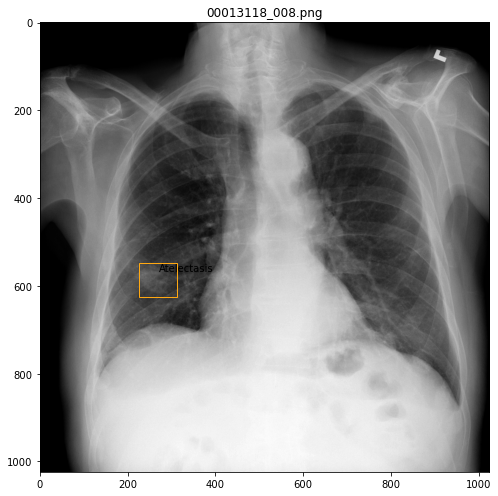

In [38]:
bounding_box_plotter_pascal_voc(img_as_arr, "00013118_008.png", bb_info_voc, get_label_2_color_dict())

### Convert Images into 512 dimensions and save BB as Pascal VOC format:

In [39]:
image_ids = sorted(annot_data["image_id"].unique())

In [40]:
image_ids[:5]

['00000032_037.png',
 '00000072_000.png',
 '00000147_001.png',
 '00000149_006.png',
 '00000181_061.png']

In [41]:
# https://stackoverflow.com/a/45172387
# iterate through all the directories
root_dir = "../input/data/"
image2path = {}
for currentpath, folders, files in os.walk(root_dir):
    for file in files:
        image2path[file] = os.path.join(currentpath, file)

In [42]:
len(image2path)

112128

In [43]:
for img_id in image_ids[:5]:
    print(image2path[img_id])

../input/data/images_001/images/00000032_037.png
../input/data/images_001/images/00000072_000.png
../input/data/images_001/images/00000147_001.png
../input/data/images_001/images/00000149_006.png
../input/data/images_001/images/00000181_061.png


In [44]:
# https://www.kaggle.com/bjoernholzhauer/eda-dicom-reading-vinbigdata-chest-x-ray#7.-Creating-fast-to-read-shelve-file
def generic_resize_image(df, image_id, image_path):
        
    # convert dicom to array
    # img_arr is PIL image format
    img_pil = Image.open(image_path)
    
    # convert images to grayscale, since VBD_CXR dataset is in grayscale
    img_pil = ImageOps.grayscale(img_pil)
    
    img_arr = np.asarray(img_pil)

    # create resize transform pipeline
    transform = albumentations.Compose([
        albumentations.Resize(width=512, height=512, always_apply=True)
    ], bbox_params=albumentations.BboxParams(format='pascal_voc')) 

    columns = ["x_min", "y_min", "x_max","y_max","class_id"]
    bboxes = get_bb_info(df, image_id, columns)

    transformed = transform(image=img_arr, bboxes=bboxes)
    
    # img_pil.size[0] = original width, img_pil.size[1] = original height
    return transformed, img_pil.size[0], img_pil.size[1]

### 512

In [45]:
dir_512 = "./external/512/"
os.makedirs(dir_512, exist_ok=True)

In [46]:
image_id = []
x_min = []
y_min = []
x_max = []
y_max = []
class_id = []
original_width = []
original_height = []
transformed_width = []
transformed_height = []

# start time
start = datetime.now()

# if filename matched with dataframe image id, then resize image and add the image into dataframe
for img_id in image_ids:
    # transform the image
    transformed, width, height = generic_resize_image(annot_data, img_id, image2path[img_id])
    
    im = Image.fromarray(transformed["image"])
    im.save(dir_512+f"/{img_id[:-4]}.png")
    
    for i in range(len(transformed["bboxes"])):
        image_id.append(img_id[:-4])
        # each row contains "x_min", "y_min", "x_max","y_max","class_id"
        x_min.append(transformed["bboxes"][i][0])
        y_min.append(transformed["bboxes"][i][1])
        x_max.append(transformed["bboxes"][i][2])
        y_max.append(transformed["bboxes"][i][3])
        class_id.append(transformed["bboxes"][i][4])
        original_width.append(width)
        original_height.append(height)
        # when using size we get width x height
        transformed_width.append(im.size[0])
        transformed_height.append(im.size[1])
    
    
    
updated_csv = pd.DataFrame({
    "image_id":image_id,
    "x_min":x_min,
    "y_min":y_min,
    "x_max":x_max,
    "y_max":y_max,
    "class_id":class_id,
    "original_width":original_width,
    "original_height":original_height,
    "transformed_width":transformed_width,
    "transformed_height":transformed_height
})
updated_csv.to_csv(f"{dir_512}/transformed_train.csv", index=False)

# end time
print("End time:"+str(datetime.now() - start))

End time:0:01:31.292744


# Verify resize operation

In [47]:
tester_id = image_ids[2]
tester_path = image2path[image_ids[2]]

## Before

In [48]:
# 'x_min', 'y_min', 'x_max', 'y_max', "class_id"
bb_info_voc = get_bb_info(annot_data, tester_id, ["x_min","y_min","x_max","y_max", "class_id"])

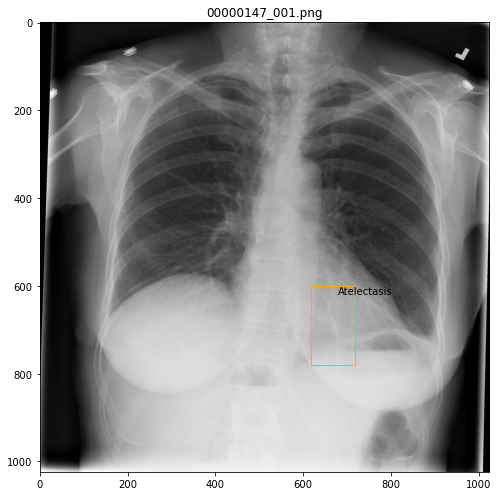

In [49]:
img_as_arr = Image.open(tester_path)
bounding_box_plotter_pascal_voc(img_as_arr, tester_id, bb_info_voc, get_label_2_color_dict())

## After

In [50]:
# 'x_min', 'y_min', 'x_max', 'y_max', "class_id"
bb_info_voc2 = get_bb_info(updated_csv, tester_id[:-4], ["x_min","y_min","x_max","y_max", "class_id"])

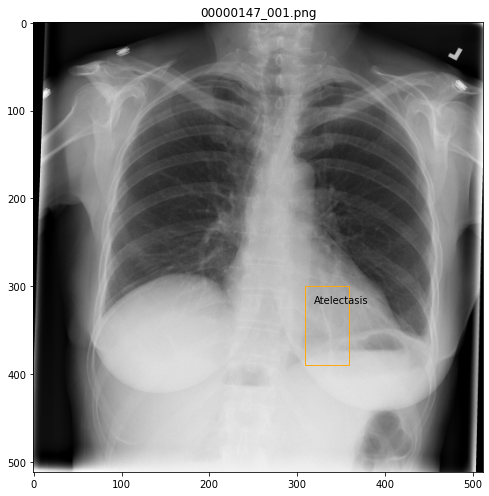

In [51]:
img_as_arr2 = Image.open(dir_512+"/"+tester_id[:-4]+".png")
bounding_box_plotter_pascal_voc(img_as_arr2, tester_id, bb_info_voc2, get_label_2_color_dict())